# 🎨 Pixel-Palette: K-Means Color Extractor

This notebook executes the K-Means clustering algorithm to find the dominant colors in an input image...

### Phase 1: Setup, Data Preparation, Display Original Image

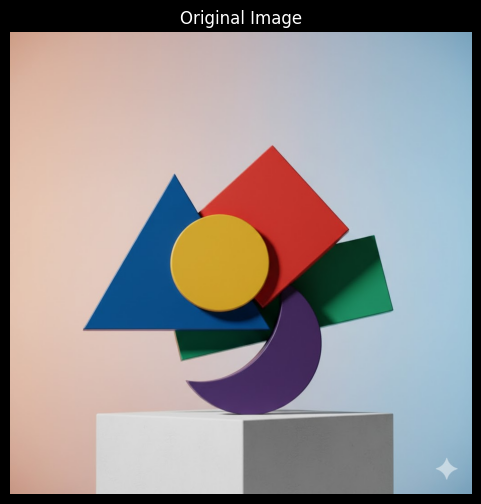

Original image shape: (1024, 1024, 3)
L*a*b image shape: (1024, 1024, 3)
K-Means input shape (Total Pixels, L*a*b): (1048576, 3)

L*a*b ranges in image:
  L: [0.04, 90.54]
  a: [-43.10, 62.55]
  b: [-42.86, 67.36]


In [ ]:
# import necessary libraries
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from typing import List
from skimage import color
from kneed import KneeLocator

np.set_printoptions(suppress=True)

# define constants & parameters
DEFAULT_K = 4  # number of colors in the palette
IGNORE_OPTIMAL_K = False  # set to True to use DEFAUL_K instead of finding optimal_K
IMAGE_SRC_NAME = 'easy_challenge.png'

IMAGE_SRC_FOLDER_PATH = 'images/source/'
IMAGE_SRC_PATH = IMAGE_SRC_FOLDER_PATH + IMAGE_SRC_NAME
IMAGE_OUTPUT_FOLDER_PATH = 'images/output/'

# load image
try:
    img = Image.open(IMAGE_SRC_PATH)
except FileNotFoundError:
    print(f"Error: The image at path {IMAGE_SRC_PATH} was not found.")
    exit()

# use dark mode
plt.style.use('dark_background')

# display original image
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
plt.show()

# convert image to numpy array
img_array = np.array(img.convert('RGB'))

# convert RGB to L*a*b color space (0-1 range)
# L*a*b space provides better color grouping for human perception
img_rgb_normalized = img_array.astype(np.float64) / 255.0
img_lab = color.rgb2lab(img_rgb_normalized)

# reshape image to a 2D array of pixels
# -1: infers number of rows, 3: L*a*b channels
pixels_lab = img_lab.reshape(-1, 3)

# display image datashapes and L*a*b ranges
print(f"Original image shape: {img_array.shape}")
print(f"L*a*b image shape: {img_lab.shape}")
print(f"K-Means input shape (Total Pixels, L*a*b): {pixels_lab.shape}")
print(f"\nL*a*b ranges in image:")
print(f"  L: [{pixels_lab[:, 0].min():.2f}, {pixels_lab[:, 0].max():.2f}]")
print(f"  a: [{pixels_lab[:, 1].min():.2f}, {pixels_lab[:, 1].max():.2f}]")
print(f"  b: [{pixels_lab[:, 2].min():.2f}, {pixels_lab[:, 2].max():.2f}]")

### Phase 2: Optimal K Analysis (Elbow Method)

#### 2.1: Inertia Calculation (K=1 to K=15) & Determinal Optimal $K$

In [ ]:
# define range of K values to test
first_k = 1
last_k = 15
k_range: List[int] = range(first_k, last_k + 1)  # include upper bound
inertias: List[float] = []

print(f"Running K-Means in L*a*b space for K={first_k} to K={last_k}...")

for k in k_range:
    # init k-means
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    # fit k-means
    kmeans.fit(pixels_lab)
    # record inertia
    # intertia_ is the sum of squared distances to nearest cluster center
    inertias.append(kmeans.inertia_)
print("K-Means runs completed. Inertias recorded.")

# determine optimal K
if not IGNORE_OPTIMAL_K:
    print("\nDetermining optimal K...")
    # decreasing and convex since inertia decreases with more clusters
    knee_locator = KneeLocator(k_range, inertias, curve='convex', direction='decreasing')

    optimal_k = knee_locator.elbow

    if optimal_k is not None:
        print(f"Optimal K (Elbow Point) determined to be: {optimal_k}")
    else:
        optimal_k = DEFAULT_K
        print(f"Warning: No elbow point detected. Defaulting to K={DEFAULT_K}.")
else:
    optimal_k = DEFAULT_K
    print(f"\nOptimal K detection ignored. Using default K={DEFAULT_K}")

Running K-Means in L*a*b space for K=1 to K=15...
K-Means runs completed. Inertias recorded.

Determining optimal K...
Optimal K (Elbow Point) determined to be: 6


#### 2.2: Elbow Plot Visualization 

Look for the 'bend/elbow' in the curve. That's the optimal K value.


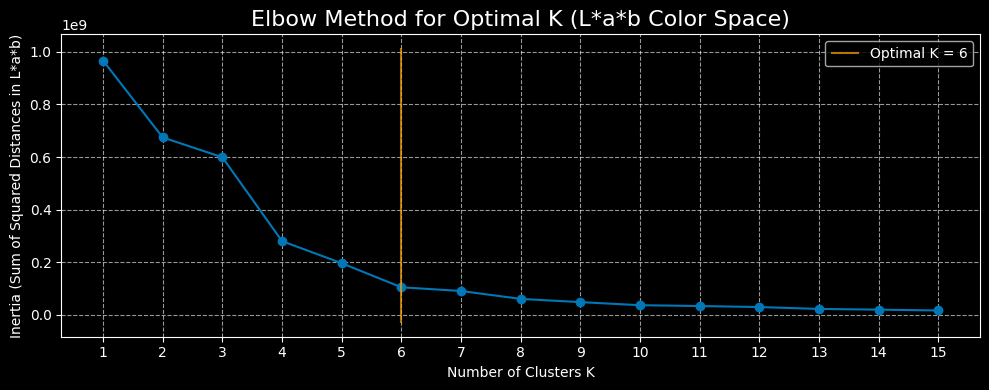

In [ ]:
# plot results to visualize the elbow point
plt.figure(figsize=(10, 4))
plt.plot(k_range, inertias, marker='o', linestyle='-', color='#0077b6')
plt.title('Elbow Method for Optimal K (L*a*b Color Space)', fontsize=16)
plt.xlabel('Number of Clusters K')
plt.ylabel('Inertia (Sum of Squared Distances in L*a*b)')
plt.xticks(k_range)
plt.grid(True, linestyle='--', alpha=0.6)

# highlight optimal K
if optimal_k:
    plt.vlines(optimal_k, 
               plt.ylim()[0], 
               plt.ylim()[1], 
               linestyles='-', 
               colors='orange', 
               alpha=0.7,
               label=f'Optimal K = {optimal_k}')
    plt.legend()

print("Look for the 'bend/elbow' in the curve. That's the optimal K value.")

plt.tight_layout()
plt.savefig(f'{IMAGE_OUTPUT_FOLDER_PATH}/elbow_plot_{IMAGE_SRC_NAME.split(".")[0]}_lab.png')
# if you want to update display image for README (default):
# plt.savefig(f'showcase_elbow_plot_default.png')
# if you want to update display image for README (optimized):
# plt.savefig(f'showcase_elbow_plot_optimized.png')
plt.show()

### Phase 3: K-Means Model Training

In [4]:
final_k = optimal_k

# initialize and train K-Means model on L*a*b data
print(f"\nTraining K-Means in L*a*b color space with K={final_k}...")
kmeans = KMeans(n_clusters=final_k, n_init='auto', random_state=42)
kmeans.fit(pixels_lab)
print("K-Means training completed.")

# get L*a*b cluster centers (dominant colors)
dominant_colors_lab = kmeans.cluster_centers_

# convert L*a*b cluster centers back to RGB for display
dominant_colors_rgb_normalized = color.lab2rgb(dominant_colors_lab.reshape(1, -1, 3)).reshape(-1, 3)
dominant_colors_rgb_normalized = np.clip(dominant_colors_rgb_normalized, 0, 1)
dominant_colors_rgb = (dominant_colors_rgb_normalized * 255).astype(int)

# display dominant colors
print(f"\n--- Model Output ---")
print("Dominant Colors (L*a*b):")
print(np.round(dominant_colors_lab, 2))
print("Dominant Colors (RGB):")
print(dominant_colors_rgb)


Training K-Means in L*a*b color space with K=6...
K-Means training completed.

--- Model Output ---
Dominant Colors (L*a*b):
[[ 41.64  53.26  37.08]
 [ 79.71   7.     7.7 ]
 [ 68.45   5.51  62.68]
 [ 27.11  11.34 -30.84]
 [ 38.94  -9.     3.32]
 [ 76.22  -4.17 -10.88]]
Dominant Colors (RGB):
[[182  47  40]
 [216 192 183]
 [205 160  43]
 [ 49  60 111]
 [ 77  95  86]
 [168 191 207]]


### Phase 4: Visualization (Sorted Palette)

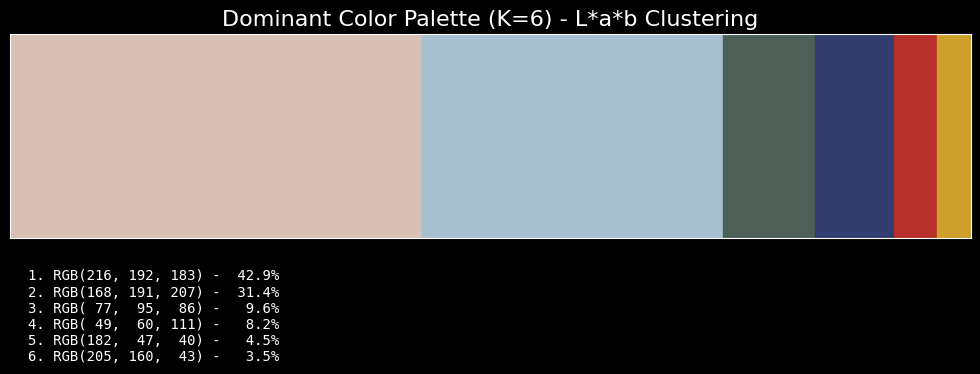

In [ ]:
# function to convert RGB to the 0-1 range for matplotlib
def rgb_to_mpl_color(rgb_tuple):
    return tuple(c / 255.0 for c in rgb_tuple)

# create figure to display dominant colors
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# weigh the colors by frequency
labels = kmeans.labels_
unique_labels, counts = np.unique(labels, return_counts=True)

# create color-proportion pairs
color_proportions = []
for label in unique_labels:
    color_rgb = dominant_colors_rgb[label]
    proportion = counts[label] / len(pixels_lab)
    color_proportions.append((color_rgb, proportion))

# sort by proportion, descending
color_proportions.sort(key=lambda x: x[1], reverse=True)

# draw the color palette
start = 0
for color, prop in color_proportions:
    end = start + prop
    # draw colored rectangle for current color
    ax.axvspan(start, end, color=rgb_to_mpl_color(color), ymin=0, ymax=1.0, alpha=1)
    start = end

# Add RGB values as list below the palette
text_lines = []
for i, (color, prop) in enumerate(color_proportions):
    text_lines.append(f"{i+1}. RGB({color[0]:3d}, {color[1]:3d}, {color[2]:3d}) - {prop*100:5.1f}%")

text_str = "\n".join(text_lines)
ax.text(0.15, -0.15, text_str, ha='center', va='top', 
        fontsize=10, color='white', transform=ax.transAxes,
        family='monospace')

ax.set_title(f'Dominant Color Palette (K={final_k}) - L*a*b Clustering', fontsize=16)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(0, 1)  # set limits from 0 to 1 for proper display of proportions
ax.set_ylim(0, 1)
plt.tight_layout()
plt.savefig(f'{IMAGE_OUTPUT_FOLDER_PATH}/color_palette_{IMAGE_SRC_NAME.split(".")[0]}_lab.png')
# if you want to update display image for README (default):
# plt.savefig(f'showcase_palette_output_default.png')
# if you want to update display image for README (optimized):
# plt.savefig(f'showcase_palette_output_optimized.png')
plt.show()